# Dependencies

# 1. Data loading

## Reading CSV (pick only one)

### FNKDD

In [301]:
data["label"].value_counts()

0        2972
1        2014
label       1
Name: label, dtype: int64

In [58]:
import pandas as pd
data = pd.read_csv("/home/rkozik/Desktop/swarog_exp_disk/datasets/fakenewskdd/train.csv",sep="\t")
data.head()
body = data["text"].values
labels = data["label"].values
total_number_of_claims = data.shape[0]
print("total_number_of_claims=",total_number_of_claims)
print("labels fake=",sum(labels),"real=", len(labels)-sum(labels))

total_number_of_claims= 4986
labels fake= 2014 real= 2972


### MMCovid

In [69]:
import pandas as pd
data = pd.read_csv("/media/rkozik/02FF-A831/data/swarog/datasets/mmcovid/news_collection.csv",sep="\t")
data["label"] = [ 1 if v =="fake" else 0 for v in data["label"]]
data["text"] = [ str(v) for v in data["text"]]
data = data[data["lang"] == "en"]

body = data["text"].values
labels = data["label"].values
total_number_of_claims = data.shape[0]
print("total_number_of_claims=",total_number_of_claims)
print("labels fake=",sum(labels),"real=", len(labels)-sum(labels))

total_number_of_claims= 7332
labels fake= 2028 real= 5304


### LIAR

In [82]:
import pandas as pd
data = pd.read_csv("/media/rkozik/02FF-A831/data/swarog/datasets/liar.csv", sep="\t",encoding="utf-8")

def mpx(x):
    if x in [0,2]:
        return 0
    elif x in [4,5]:
        return 1
    else:
        return -1

data["text"] = data["statement"]
data["label"] = [mpx(x) for x in data["label"]]
data=data[ data["label"] != -1] 

body = data["text"].values
labels = data["label"].values
total_number_of_claims = data.shape[0]
print("total_number_of_claims=",total_number_of_claims)
print("labels fake=",sum(labels),"real=", len(labels)-sum(labels))

total_number_of_claims= 8061
labels fake= 3554 real= 4507


### COVID Fake News 

In [3]:
!id="18nemaqdNT-0ZtEWyD57a6tO3LXUcgtMj"; conf=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$id -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p'); wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$conf&id=$id" -O covid_fake_news.csv && rm -rf /tmp/cookies.txt

--2023-04-06 08:54:10--  https://docs.google.com/uc?export=download&confirm=&id=18nemaqdNT-0ZtEWyD57a6tO3LXUcgtMj
Resolving docs.google.com (docs.google.com)... 142.250.203.206, 2a00:1450:401b:810::200e
Connecting to docs.google.com (docs.google.com)|142.250.203.206|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-34-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ucatkg3c4v0u7h5lgrm1t1g9oippc4fu/1680764025000/05536367513713019519/*/18nemaqdNT-0ZtEWyD57a6tO3LXUcgtMj?e=download&uuid=c940567a-e6bb-42c7-be40-41cd9d24ac0c [following]
--2023-04-06 08:54:11--  https://doc-00-34-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ucatkg3c4v0u7h5lgrm1t1g9oippc4fu/1680764025000/05536367513713019519/*/18nemaqdNT-0ZtEWyD57a6tO3LXUcgtMj?e=download&uuid=c940567a-e6bb-42c7-be40-41cd9d24ac0c
Resolving doc-00-34-docs.googleusercontent.com (doc-00-34-docs.googleusercontent.com)... 192.178.25.161, 2a00:1450:

In [4]:
import pandas as pd
data = pd.read_csv("covid_fake_news.csv", sep="\t")
body = data["title"].values
labels = data["label"].values
total_number_of_claims = data.shape[0]
print("total_number_of_claims=",total_number_of_claims)
print("labels fake=",sum(labels),"real=", len(labels)-sum(labels))

total_number_of_claims= 8972
labels fake= 461 real= 8511


## Spliting Training/Testing

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
X=np.array(range(0,total_number_of_claims))
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.43, random_state=12345)
print("Train:", X_train.shape,{1:sum(y_train),0:len(y_train)-sum(y_train)})
print("Test:",X_test.shape,{1:sum(y_test),0:len(y_test)-sum(y_test)})

Train: (5114,) {1: 258, 0: 4856}
Test: (3858,) {1: 203, 0: 3655}


# 2. Training

In [6]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.metrics import geometric_mean_score


class Metrics:
    def __init__(self):
        self.scores = {
            'Accuracy': {'func': accuracy_score},
            'Balanced Accuracy': {'func': balanced_accuracy_score},
            'F1': {'func': f1_score},
            'Precision': {'func': precision_score},
            'Recall': {'func': recall_score},
            'G-mean': {'func': geometric_mean_score}
        }
        
        for score_name, score_dict in self.scores.items():
            score_dict["list"] = []
            score_dict["lab"] = []

    def update(self, actual, prediction):
        for score_name, score_dict in self.scores.items():
            if score_name in ["F1","Precision","Recall","G-mean"]:
                scorvaln = score_dict['func'](actual, prediction, average=None)
                score_dict['lab'].append(scorvaln)
                scorval = score_dict['func'](actual, prediction, average="weighted")
                score_dict['list'].append(scorval)
                #print(score_name, scorval, scorvaln)  
            else:
                scorval=score_dict['func'](actual, prediction)
                score_dict['list'].append(scorval)
                
    def print_table(self, labels=None):
        # Print stats
        scores = self.scores
        numlabels = scores["F1"]["lab"][0].shape[0]
        scores["F1"]["lab"][0].shape[0] 
        head = "  %-20s  %-10s  " +  numlabels * " %-10s  " 
        headv = ["Score", "Average"]
        if labels:
            headv.extend([labels[i] for i in range(numlabels)])
        else:
            headv.extend(["Kat_"+str(i+1) for i in range(numlabels)])
        row=head % tuple(headv)
        # table header
        print("―"*len(row))
        print(row)
        print("―"*len(row))
        # table rows
        for score_name, score_dict in sorted(scores.items()) :
            headv = [score_name, np.mean(score_dict['list'])*100, np.std(score_dict['list'])*100]
            for i in range(numlabels):
                if score_name in ["F1","Precision","Recall", "G-mean"]:
                    head = "  %-20s  %4.1f ± %4.1f  " + numlabels* "%4.1f ± %4.1f  "
                    vals = [v[i] for v in scores[score_name]["lab"]]
                    headv.append(np.mean(vals)*100)
                    headv.append(np.std(vals)*100)
                else:
                    head = "  %-20s  %4.1f ± %4.1f  " + numlabels * "%-11s  " 
                    headv.append("-")
            print(head % tuple(headv))
        print("―"*len(row))

## Fit TFIDF on training data

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords

# Download stopwords list
nltk.download('wordnet')
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

# Interface lemma tokenizer from nltk with sklearn
class LemmaTokenizer:
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`', "'"]
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]

# Lemmatize the stop words
tokenizer=LemmaTokenizer()
token_stop = tokenizer(' '.join(stop_words))


# Create TF-idf model
tfidf_vectorizer = TfidfVectorizer(stop_words=token_stop)
tfidf_vectorizer.fit(body[X_train])

vocabulary_tfidf_words = tfidf_vectorizer.get_feature_names_out()


[nltk_data] Downloading package wordnet to /home/rkozik/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/rkozik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2.1 Building graph

### Utility functions

In [8]:
def tfidf_to_words(vec):
    li=sorted(list(zip(vec[np.where(vec > 0)], vocabulary_tfidf_words[np.where(vec > 0)[0]])), key=lambda tup: -tup[0])
    words = [x[1] for x in li]
    return words

In [9]:
def get_graph_node_stats(vec, nearestDocIDs):   
    vecdense = vec.toarray()[0]
    docids = nearestDocIDs
    trlabels = np.array(y_train)
    labsum = trlabels[docids].sum()
    
    ivec = []
    labmask = []
    for hitdocid in docids:
        value=bodyTrainTFIDF[hitdocid].toarray()[0]
        intersection = (vecdense>0)*(value>0)
        ivec.append(intersection.sum())
        labmask.append(trlabels[hitdocid])
        
    masked_ivec =  np.array(ivec)*np.array(labmask)   
    masked_ivec_neg =  np.array(ivec)*(-1*(np.array(labmask)-1)) 
    ivec = np.array(ivec)
    masked_ivec = np.array(masked_ivec)
    masked_ivec_neg = np.array(masked_ivec_neg)
    
    newvec = [labsum, (vecdense>0).sum(),ivec.max(), ivec.max(), masked_ivec.max(), masked_ivec.min(), masked_ivec_neg.max(), masked_ivec_neg.min()]
    return newvec

### Fitting KNN

In [10]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

bodyTrainTFIDF = tfidf_vectorizer.transform(body[X_train]) 
nn = NearestNeighbors(n_neighbors=10)
nn.fit(bodyTrainTFIDF)

NearestNeighbors(n_neighbors=10)

### Extracting stats for all nodes in the graph

In [12]:
knn_d,knn_idx = nn.kneighbors(bodyTrainTFIDF)
graph_knn = []
from tqdm import tqdm
for id, topIDs in tqdm(enumerate(knn_idx), total=knn_idx.shape[0]):
    vec = bodyTrainTFIDF[id]
    newvec = get_graph_node_stats(vec, topIDs[1:])
    graph_knn.append(newvec)
    
import pickle
with open("knn_graph.pkl","wb") as f:
    pickle.dump(graph_knn, f)
    
print("avg.sim.=",np.mean([x[2]/x[1] for x in graph_knn]))

100%|█████████████████████████████████████| 5114/5114 [00:04<00:00, 1113.64it/s]


In [17]:
# Collecting statistics

# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# import sqlite3
# con = sqlite3.connect("distmeasure.db")
# con.execute("create table if not exists measures(ds,val)")
# con.commit()

# vsim = [x[2]/x[1] for x in graph_knn]
# for x in vsim:
#     con.execute("insert into measures values('covidfn',?)",[x])
# con.commit()
# con.close()


In [14]:
# Extracting stats for new (testing) data samples

bodyTestTFIDF = tfidf_vectorizer.transform(body[X_test]) 
knn_test_d,knn_test_idx = nn.kneighbors(bodyTestTFIDF)


graph_test_knn = []
for id, topIDs in tqdm(enumerate(knn_test_idx), total=knn_test_idx.shape[0]):
    vec = bodyTestTFIDF[id]
    newvec = get_graph_node_stats(vec, topIDs[1:])
    graph_test_knn.append(newvec)
    
np.array(graph_test_knn).shape

100%|█████████████████████████████████████| 3858/3858 [00:03<00:00, 1119.38it/s]


(3858, 8)

### Checking quality of Graph-based features

In [19]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.metrics import geometric_mean_score
from IPython.display import clear_output

from sklearn.linear_model import LogisticRegression

cls = LogisticRegression(max_iter=10000)
cls.fit(graph_knn, y_train)
y_pred = cls.predict(graph_test_knn)

m = Metrics()
m.update(y_test,y_pred)
m.print_table()

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Score                 Average      Kat_1        Kat_2       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Accuracy              96.2 ±  0.0  -            -            
  Balanced Accuracy     68.0 ±  0.0  -            -            
  F1                    95.5 ±  0.0  98.0 ±  0.0  50.2 ±  0.0  
  G-mean                61.9 ±  0.0  60.2 ±  0.0  60.2 ±  0.0  
  Precision             95.7 ±  0.0  96.6 ±  0.0  80.4 ±  0.0  
  Recall                96.2 ±  0.0  99.5 ±  0.0  36.5 ±  0.0  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――



## 2.2 Content classifier

### Utilities

In [20]:
import numpy as np
import bentoml
from bentoml.io import NumpyNdarray
from bentoml.io import JSON
from annoy import AnnoyIndex
import re

import transformers
transformers.logging.set_verbosity_error()
from torch.utils.data import DataLoader 

from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import TFDistilBertModel, DistilBertTokenizerFast
import torch
from scipy.sparse import csr_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
import pickle5 as pickle
import sqlite3
from tqdm import tqdm
#PATH_PICKLES = '../../pickles'
 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("using device:", device)

if "disilbert_model" not in locals():
    disilbert_tokenizer =  AutoTokenizer.from_pretrained("distilbert-base-uncased")
    disilbert_model = AutoModel.from_pretrained("distilbert-base-uncased")
    handle = disilbert_model.to(device)

class BERTEmbeddings:
    def __init__(self):
        self.tokenizer =  disilbert_tokenizer
        self.model = disilbert_tokenizer
        self.max_length = 256
        self.model_name = disilbert_model

    def fit(self, X=None, y=None):
        pass
    
    def encode(self, txt):
        return self.tokenizer(txt, max_length=self.max_length, 
                              truncation=True, padding=True, return_tensors="pt")

    def transform(self, X=None):
        dataloader = DataLoader(X, batch_size=4, shuffle=False)
        allembeds = []
        for batch in tqdm(dataloader):
            batchenc = disilbert_tokenizer(batch, max_length=256, 
                                           truncation=True, padding=True, return_tensors="pt")
            input_ids = batchenc['input_ids'].to(device)
            attention_mask = batchenc['attention_mask'].to(device)
            batchout = disilbert_model(input_ids, attention_mask=attention_mask, 
                                       output_hidden_states=True)
            embeds = [vec[0].cpu().detach().numpy() for vec in batchout[1][-1]]
            allembeds.extend(embeds)
        return np.array(allembeds)

using device: cuda


### Extracting BERT embeddings

In [21]:
berd_encoder = BERTEmbeddings()
body_berts = berd_encoder.transform(body)

100%|██████████████████████████████████████| 2243/2243 [00:13<00:00, 169.10it/s]


In [22]:
body_berts.shape

(8972, 768)

### Checking quality of the content classifier

In [24]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.metrics import geometric_mean_score
from IPython.display import clear_output

from sklearn.linear_model import LogisticRegression

covid_fake_news_bert_cls = body_berts
cls = LogisticRegression(max_iter=1000)

cls.fit(covid_fake_news_bert_cls[X_train], y_train)

bert_y_pred_train = [x[1] for x in cls.predict_proba(covid_fake_news_bert_cls[X_train])]
bert_y_pred_test = [x[1] for x in cls.predict_proba(covid_fake_news_bert_cls[X_test])]
balanced_accuracy_score(y_test,[1 if x >= 0.5 else 0 for x in bert_y_pred_test])

m = Metrics()
m.update(y_test,[1 if x >= 0.5 else 0 for x in bert_y_pred_test])
m.print_table()

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Score                 Average      Kat_1        Kat_2       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Accuracy              97.2 ±  0.0  -            -            
  Balanced Accuracy     77.8 ±  0.0  -            -            
  F1                    96.9 ±  0.0  98.5 ±  0.0  67.7 ±  0.0  
  G-mean                75.4 ±  0.0  74.7 ±  0.0  74.7 ±  0.0  
  Precision             97.0 ±  0.0  97.6 ±  0.0  85.1 ±  0.0  
  Recall                97.2 ±  0.0  99.5 ±  0.0  56.2 ±  0.0  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


# 3. Merge Inference

### Combining all the soruces

In [25]:
newX=[]
bert_x = covid_fake_news_bert_cls[X_train]
for i,vec in enumerate(bert_x):
    #v2 = np.append(vec, graph_knn[i])
    v2 = np.append(bert_y_pred_train[i], graph_knn[i])
    newX.append(v2)

In [26]:
newTest=[]
bart_xt=covid_fake_news_bert_cls[X_test]
for i,vec in enumerate(bart_xt):
    #v2 = np.append(vec, graph_test_knn[i])
    v2 = np.append(bert_y_pred_test[i], graph_test_knn[i])
    newTest.append(v2)

### Observing the boost in the quality

In [27]:
inf = LogisticRegression(max_iter=10000)
inf.fit(newX, y_train)
y_pred = inf.predict(newTest)
balanced_accuracy_score(y_test,y_pred)

0.8070616538515968

In [28]:
from sklearn.ensemble import RandomForestClassifier
inf = RandomForestClassifier(max_depth=12)
inf.fit(newX, y_train)
y_pred = inf.predict(newTest)
balanced_accuracy_score(y_test,y_pred)

0.8169145444865997

In [29]:
m = Metrics()
m.update(y_test,y_pred)
m.print_table()

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Score                 Average      Kat_1        Kat_2       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  Accuracy              97.0 ±  0.0  -            -            
  Balanced Accuracy     81.7 ±  0.0  -            -            
  F1                    96.9 ±  0.0  98.4 ±  0.0  69.7 ±  0.0  
  G-mean                80.2 ±  0.0  79.9 ±  0.0  79.9 ±  0.0  
  Precision             96.9 ±  0.0  98.0 ±  0.0  75.7 ±  0.0  
  Recall                97.0 ±  0.0  98.9 ±  0.0  64.5 ±  0.0  
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


# Graph and plots

[('covidfn', 5114), ('fnkdd', 2842), ('liar', 4594), ('mcovid', 4179)]
19 20
19 20
19 20
19 20
               fnkdd   covidfn      liar   mmcovid
similarity                                        
0.052632    0.000751  0.000000  0.000221  0.003902
0.105263    0.003754  0.002211  0.004410  0.009904
0.157895    0.016141  0.018094  0.038148  0.020408
0.210526    0.053679  0.049457  0.100551  0.032713
0.263158    0.099474  0.081423  0.157001  0.073830
0.315789    0.122748  0.108967  0.180154  0.115846
0.368421    0.120495  0.108967  0.140243  0.168367
0.421053    0.128754  0.122638  0.112900  0.149160
0.473684    0.129505  0.107559  0.082470  0.127851
0.526316    0.115616  0.106152  0.080926  0.100840
0.578947    0.087462  0.064536  0.030430  0.056122
0.631579    0.061937  0.059509  0.025799  0.035114
0.684211    0.030405  0.048251  0.020948  0.024610
0.736842    0.014640  0.025332  0.007277  0.023109
0.789474    0.006006  0.032368  0.007056  0.014406
0.842105    0.002252  0.033776  0.0063

[Text(0, 0.5, 'Probability'), Text(0.5, 0, 'Documents Similarity Score')]

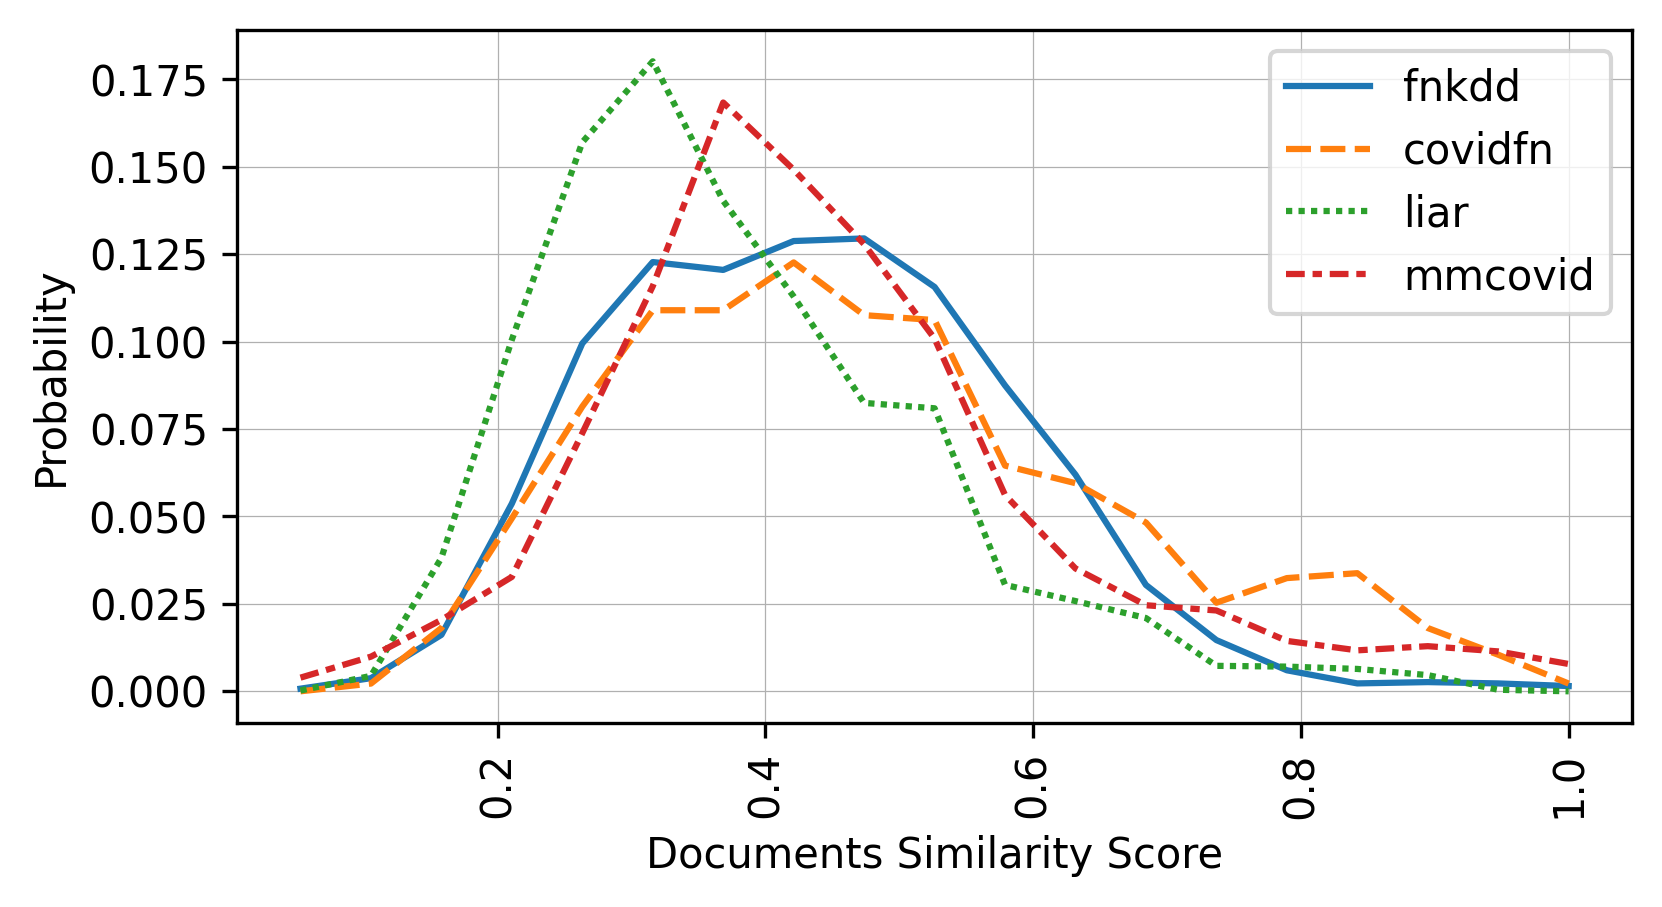

In [179]:
import sqlite3
con = sqlite3.connect("distmeasure.db")
print(con.execute("select ds,count(*) from measures group by 1").fetchall())

fnkdd, ranges = np.histogram([x[0] for x in con.execute("select val from measures where ds='fnkdd' and val <1").fetchall()], bins=np.linspace(.0, 1, num=20))
print(len(fnkdd), len(ranges))
covidfn, ranges = np.histogram([x[0] for x in con.execute("select val from measures where ds='covidfn' and val <1").fetchall()], bins=ranges)
print(len(covidfn), len(ranges))
liar, ranges = np.histogram([x[0] for x in con.execute("select val from measures where ds='liar' and val <1").fetchall()], bins=ranges)
print(len(liar), len(ranges))
mmcovid, ranges = np.histogram([x[0] for x in con.execute("select val from measures where ds='mcovid' and val <1").fetchall()], bins=ranges)
print(len(mmcovid), len(ranges))

data=pd.DataFrame({'similarity':ranges[1:], 'fnkdd':fnkdd/fnkdd.sum(), 'covidfn':covidfn/covidfn.sum(), 'liar':liar/liar.sum(), 'mmcovid':mmcovid/mmcovid.sum()})
#data.to_sql("hist", con)
con.close()

plt.rcParams.update({'figure.figsize': (6, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
data=data.set_index("similarity")
print(data)
sns.lineplot(data=data)
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
ax.set(ylabel='Probability', xlabel='Documents Similarity Score')